In [3]:
import scipy.sparse as sp
addendums = ['doc2topic','w2topic','w2count_topic']
def load_data(model):
    path = result_path+model
    data = []
    for add in addendums:
        filename = path+'_%s.npz'%(add)
        mat = sp.load_npz(filename)
        data.append(mat)#[add] = mat
    return data
base = '/home/snorre/Dropbox/Forskning/bigdata/data_inspections/'
meta_path = base+'simulation_results/metrics/'
meta_path2 = base+'simulation_results/distributions/'
from os import listdir
result_path = '/mnt/b0c8e396-e5ba-4614-be6f-146c4c861ab3/data/topic_model_simulation/models/'
model_runs = set(['_'.join(i.split('_')[0:3]) for i in listdir(result_path)])
model_runs = sorted(model_runs,key=lambda x: int(x.split('_')[-1]))
import random

data = load_data(random.choice(model_runs))

In [4]:
doc2topic = data[0].toarray()

In [6]:
doc2topic = doc2topic[0:46209]

In [12]:
import scipy.stats
def normalize_entropy(series):
    result = scipy.stats.entropy(((series.T/series.sum(axis=1)).T).T)
    return result
entropies = normalize_entropy(doc2topic.T)


In [22]:
import numpy as np

top_dist = np.linspace(0,1,10)

#np.bincount()

In [55]:
def binning(x,scale=0.05):
    return x-x%scale
binning(1.576)
scale = 0.05
bins = np.arange(0,1+scale,scale)
from collections import Counter
def bin_counts(a):
    c = Counter(binning(a))
    return [c[i] for i in bins]
def bin_counts2(a):
    c = Counter(vec_bin(a))
    return [c[i] for i in bins]
bin_counts(np.linspace(0,1,20))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

In [15]:
import scipy.sparse as sp
def run_analysis(func):
    "Runs a function on the raw data. Expects a function that returns a list where each row is a "
    # Load models    
    dfs = [] # dataframe container
    for model in tqdm(model_runs):
        model_n = int(model.split('_')[-1])
        data = load_data(model)
        temp_df = func(data)
        temp_df['topic_num'] = np.arange(len(temp_df))
        temp_df['model_path'] = model
        temp_df['model_id'] = model_n
        dfs.append(temp_df)
    df = pd.concat(dfs)
    return df

In [102]:
import pandas as pd
meta_files = [meta_path+i for i in listdir(meta_path)]
dfs = []
for num,filename in enumerate(meta_files):
    df = pd.read_csv(filename)
    df['simulation_id'] = num
    dfs.append(df)
df = pd.concat(dfs)
df = df.sort_values('modelid')
del dfs

In [103]:
## remove ambivalent runs
c = Counter([i.split('_')[-1] for i in model_runs])
model_errors = set(df.modelid.value_counts().index[df.modelid.value_counts()>1])
model_errors.update(set([int(i) for i,count in c.most_common(len(c)) if count>1]))
df = df[~df.modelid.isin(model_errors)]
df = df[df.simulation_id.isin(set(df.simulation_id.value_counts()[df.simulation_id.value_counts()==29].index))]
df.shape

(8091, 13)

In [105]:
import random
# sample for first analysis
n_simulations = 3# maximum is 13 
sample_simulations = set(np.concatenate(df.groupby(['noise']).apply(lambda x: random.sample(set(x.simulation_id.values),n_simulations)).values))
print(df[df.simulation_id.isin(sample_simulations)].n_topics.sum())
modelids = set(df[df.simulation_id.isin(sample_simulations)].modelid)

model_runs = sorted([i for i in model_runs if int(i.split('_')[-1]) in modelids],key=lambda x: int(x.split('_')[-1]))

139200


In [146]:
import pandas as pd
import numpy as np
def get_doc_entropy(data):
    doc2topic = data[0].toarray()
    doc2topic = doc2topic[0:46209]
    entropies = normalize_entropy(doc2topic.T)
    
    dat = []
    for vec in np.digitize(doc2topic.T,bins):
        c = Counter(vec)
        a = {round(bins[num-1],2):c[num] for num in range(1,len(bins)+1)}
        dat.append(a)
    
    quantile_counts = pd.DataFrame(dat)
    # weight of each quantile
    dat2 = []
    for vec in doc2topic.T:
        binned = np.digitize(vec,bins)
        size = vec.sum()
        perc = []
        for i in range(1,len(bins)+1):
            perc.append(vec[binned==i].sum()/size)
        dat2.append(perc)
    quantile_counts2 = pd.DataFrame(dat2,columns=['w_%.2f'%i for i in bins])
    
    temp = pd.DataFrame({'doc_entropy':entropies})
    temp = pd.concat([temp,quantile_counts,quantile_counts2],axis=1)
    return temp

from tqdm import tqdm_notebook as tqdm

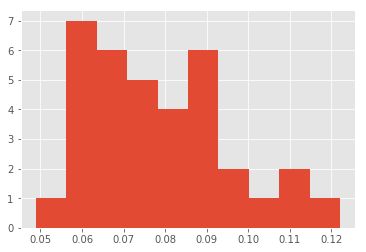

In [150]:
get_doc_entropy(data)['w_0.10'].hist()

In [151]:
ent_df = run_analysis(get_doc_entropy)

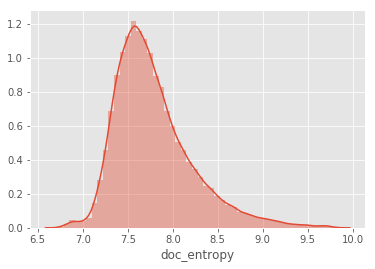

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.distplot(ent_df.doc_entropy)

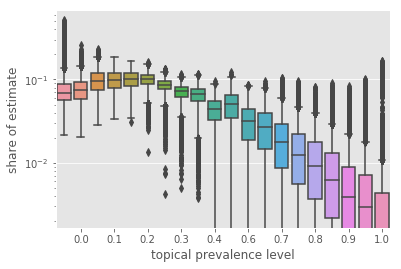

In [160]:
plt.style.use('ggplot')
sns.boxplot(x='level_1',y=0,data=(ent_df[[col for col in ent_df.columns if type(col)!=float and 'w_' in col]]).stack().reset_index())
plt.yscale('log')
plt.xlabel('topical prevalence level')
plt.ylabel('share of estimate')
plt.xticks(np.arange(1,20,2),[round(i,1) for i in np.linspace(0,1,10)]);
plt.savefig('output/descriptives/topical_prevalence_levels_share.png')

In [139]:
#sns.boxplot(ent_df[[col for col in ent_df.columns if  type(col)==float]].stack().reset_index())

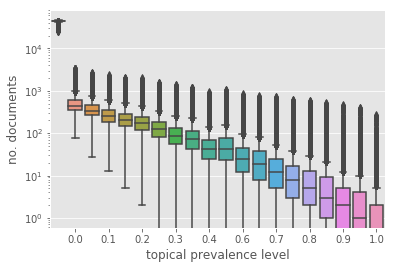

In [143]:
plt.style.use('ggplot')
sns.boxplot(x='level_1',y=0,data=(ent_df[[col for col in ent_df.columns if  type(col)==float]]).stack().reset_index())
plt.yscale('log')
plt.xlabel('topical prevalence level')
plt.ylabel('no. documents')
plt.xticks(np.arange(1,20,2),[round(i,1) for i in np.linspace(0,1,10)]);
plt.savefig('output/descriptives/topical_prevalence_levels_variation.png')